In [2]:
import xarray
import numpy
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

In [4]:
# Create a dictionary with all variable options (these can be expanded)
variable_name_list=['DO','NH3','NO3','NPP','Temp','Salinity']
parameter_ID_list=['Var_10','Var_14','Var_15','Var_17','Var_18','Var_19']
model_output_name = {
    variable_name_list[i]: parameter_ID_list[i] for i in range(len(variable_name_list))
}

# Define the variable that we want to plot
variable_name = "DO" 

# Define directory for saving netcdf output
output_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/output/daily_min')
graphics_directory= pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/graphics')


# Define locations for different scenarios
root_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/')
data_paths=numpy.array(
    [root_dir/'2014_SSM4_WQ_exist_orig/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_ref_orig/hotstart/outputs'
    ]
)

# Functions

In [5]:
def reshape_fvcom(fvcom_timeIJK, reshape_type):
    """ Reorganize the 2D FVCOM output from 2-dimensions of (time,nodes)
    to a format that allows for daily, yearly, or depth calculations. 
    
    param float fvcom_timeIJK: FVCOM_v2.7ecy output array in dimension of 8760x160120.
    param string reshape_type: ['days','levels','dayslevels']
    return: Reorganized array
    """
    ti,ni = fvcom_timeIJK.shape
    print(ti,ni)
    # Error handling
    if reshape_type not in ['days','levels','dayslevels']:
        raise ValueError(
            "options for reshape_type are: 'days','levels','dayslevels'"
        )
    
    # Reshaping
    if reshape_type == 'days':
        if (ti != 8760):
            raise TypeError(
                "FVCOM array must have a time dimension of 8760"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,ni)
        )
    elif reshape_type == 'levels':
        if (ni != 160120):
            raise TypeError(
                "FVCOM array must have a node dimension of 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (ti,16012,10)
        )
    elif reshape_type == 'dayslevels':
        if (ti != 8760) or (ni != 160120):
            raise TypeError(
                "FVCOM array size must be 8760 x 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,16012,10)
        )
        
    return fvcom_reshaped

def extract_fvcom_level(gdf, fvcom_timeIJK, LevelNum):
    """ Extract model output at nodes by level. 
    
    param dataframe gdf: geopandas dataframe of FVCOM nodes from 2D planar nodes
        with dimensions of 16012.
    param float fvcom_timeIJK: 3D-FVCOM output in dimensions of time x 160120.
    param int LevelNum: Integer from 1 (surface) to 10 (bottom)
    
    return fvcom_nodeIDs: model output at level in dimension of time x 16012
    """
    if LevelNum not in range(1,11):
        raise ValueError("fvcom_LevelNum must be an integer value from 1-10")

    try:
        node_ids = gdf['node_id'].to_numpy()
    except:
        raise AttributeError("missing 'node_id' column in dataframe")
        
    ijk_index = node_ids * 10 - (11-LevelNum)
    # get DO values at each level
    fvcom_nodeIDs = fvcom_timeIJK[:,ijk_index]
    # if ds['Var_10'] is passed in: 
    # fvcom_nodeIDs = fvcom_timeIJK[:,:].data[:,ijk_index]
    
    return fvcom_nodeIDs

def calc_fvcom_stat(fvcom_output, stat_type, axis):
    """ Perform numpy statistic (e.g. mean, min) on FVCOM_v2.7ecy model output 
        over specific "axis." 
    
    param float fvcom_output: FVCOM_v2.7ecy output array in dimensions of time x 160120.
    param float stat_type: 'min','mean'.
    param int axis: Integer from 0 to ndims(fvcom_output)
    
    return: stat of model output across specified axis (axs)
    """
    fvcom_stat = getattr(numpy,stat_type)(fvcom_output,axis=axis)
    
    return fvcom_stat

# Load model output from the Existing and Reference cases

In [9]:
si = 0 # choose first directory = Existing
dailyDO_tmin_zmin={}
variable_name = 'DO'
for si in [0,1]:
    scenario_name=str(data_paths[si]).split('/')[-3]
    # output netcdf filename
    output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
    # input netcdf filename
    file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
    # load variable into xarray and calculate daily min.
    with xarray.open_dataset(file_path) as ds:
        dailyDO = reshape_fvcom(
            ds[model_output_name[variable_name]][:,:].data, 
            'days'
        ) #return (365x24xnodes)
        # calculate daily minimum
        dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
        # calculate daily minimum across 265 days
        dailyDO_tmin = calc_fvcom_stat(dailyDO_tmin, 'min', axis=0)
        # reshape to levels
        dailyDO_tmin_rshp = numpy.reshape(
            dailyDO_tmin, (16012,10)
        )
        # calculate minimum across depth levels
        dailyDO_tmin_zmin[si] = calc_fvcom_stat(dailyDO_tmin_rshp, 'min', axis=1)
# dialy min DO difference Existing - Reference
dailyDO_tmin_zmin[2] = dailyDO_tmin_zmin[0]-dailyDO_tmin_zmin[1]
dailyDO_tmin_zmin[2].shape

8760 160120
8760 160120


(16012,)

# Plot histograms of DO together with 5% and 95% quantiles

In [10]:
hist_labels = ['Existing','Reference','Existing-Reference']
hist_colors=['darkslategrey','darkblue','indigo']

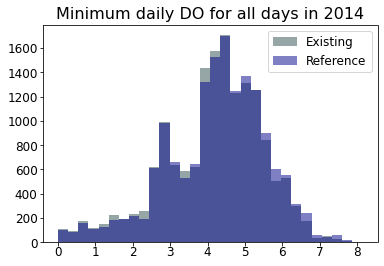

In [16]:
for si in [0,1]:
    plt.hist(dailyDO_tmin_zmin[si], 
             bins=30,
             alpha=0.5, 
             label=hist_labels[si],
             color=hist_colors[si]) # customized color parameter  
plt.title('Minimum daily DO for all days in 2014')
plt.legend(loc='upper right')
plt.show()

# Show histograms for all regions

In [17]:
# Kevin's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/shapefiles'
)/'SSMGrid2_tce.shp'
gdf_k = gpd.read_file(shapefile_path)
gdf_k = gdf_k.loc[:, ('tce','Basin','geometry')]
gdf_k=gdf_k.rename(columns={'tce':'node_id'})
basin_count=gdf_k[['node_id','Basin']].groupby('Basin').count().rename(columns={'node_id':'node count'})
basin_count

,node count
Basin,
Hood Canal,726
Main Basin,1208
SJF_Admiralty,958
SOG_Bays,743
South Sound,1722
Whidbey_Basin,2067


In [21]:
basin_count.index.to_list()

['Hood Canal',
 'Main Basin',
 'SJF_Admiralty',
 'SOG_Bays',
 'South Sound',
 'Whidbey_Basin']

In [37]:
# separate nodes by basin
gdf = {}
minDO={}
for basin in basin_count.index.to_list():
    minDO[basin]={}
    gdf[basin] = gdf_k.loc[gdf_k['Basin']==basin]
    # use node_id to select locations
    for si in [0,1,2]:
        minDO[basin][si] = dailyDO_tmin_zmin[si][gdf[basin]['node_id']-1]

0
1
2
3
4
5


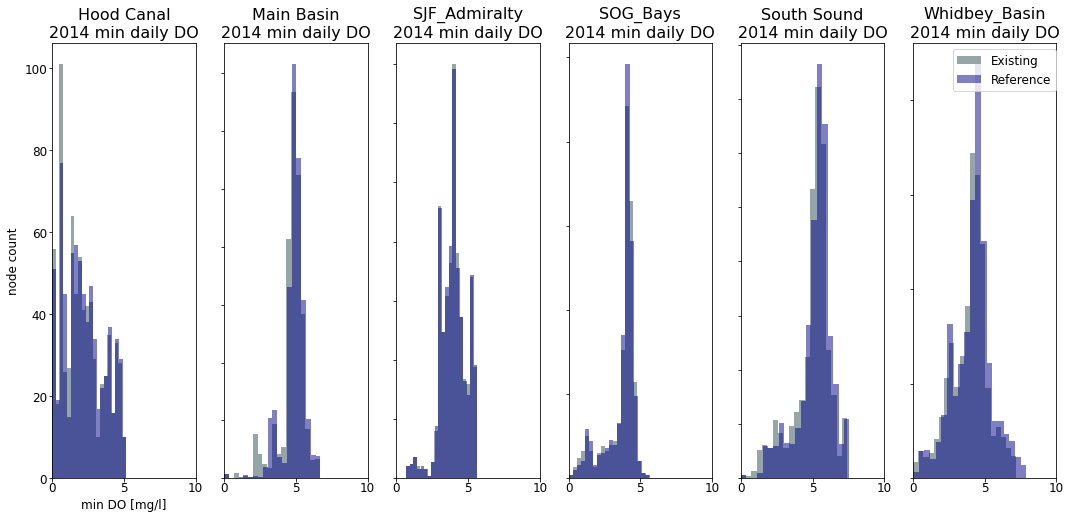

In [42]:
fig, axs = plt.subplots(1,6, figsize = (18,8))
for idx,basin in enumerate(basin_count.index.to_list()):
    print(idx)
    for si in [0,1]:
        axs[idx].hist(minDO[basin][si], 
                 bins=20,
                 alpha=0.5, 
                 label=hist_labels[si],
                 color=hist_colors[si]) # customized color parameter  
    axs[idx].set_title(f'{basin}\n2014 min daily DO')
    axs[idx].set_xlim(0,10)
    if idx>0:
        axs[idx].set(yticklabels='')
    else:
        axs[idx].set_ylabel('node count')
        axs[idx].set_xlabel('min DO [mg/l]')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper right')
plt.show()

0
1
2
3
4
5


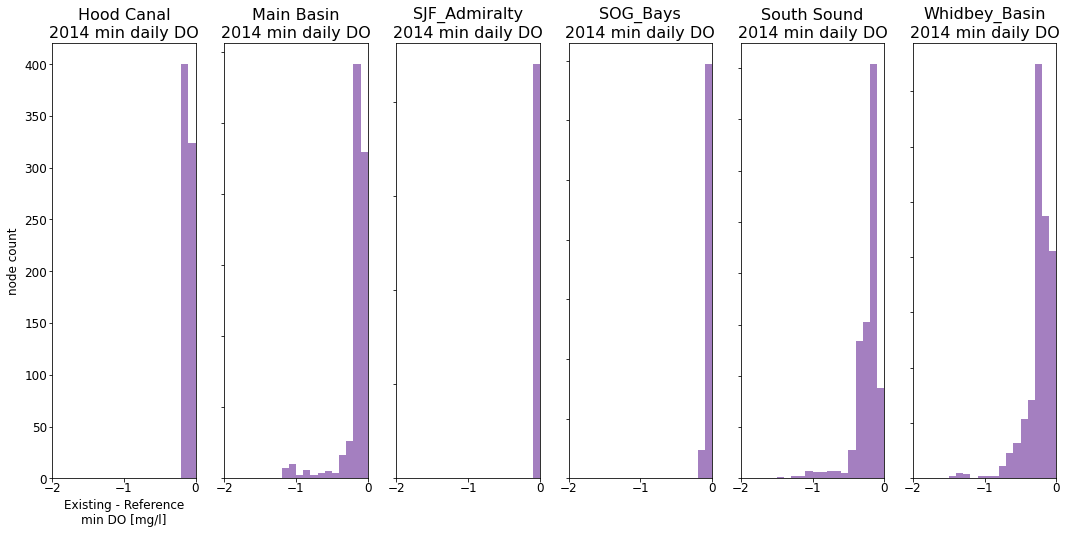

In [47]:
fig, axs = plt.subplots(1,6, figsize = (18,8))
si=2
for idx,basin in enumerate(basin_count.index.to_list()):
    print(idx)
    axs[idx].hist(minDO[basin][si], 
             bins=15,
             range=(-1.5, 0),
             alpha=0.5, 
             label=hist_labels[si],
             color=hist_colors[si]) # customized color parameter  
    axs[idx].set_title(f'{basin}\n2014 min daily DO')
    axs[idx].set_xlim(-2,0)
    if idx>0:
        axs[idx].set(yticklabels='')
    else:
        axs[idx].set_ylabel('node count')
        axs[idx].set_xlabel('Existing - Reference\nmin DO [mg/l]')
#plt.legend(bbox_to_anchor=(1.04,1),loc='upper right')
plt.show()